In [24]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from sympy import *
from sympy.plotting import plot as syplot

init_printing() 

In [2]:
Vin = Function('Vin')
Vrect = Function('Vrect')
VL = Function('VL')
Vout = Function('Vout')
I = Function('I')
e = Function('e')
A, ω, t, L, R, C = symbols('A ω t L R C')
I = Vout(t) / R
dIdt = diff(I,t)
R = 1
C = 1

First, define Vin as a sine wave with amplitude 'A' and frequency 'ω'.

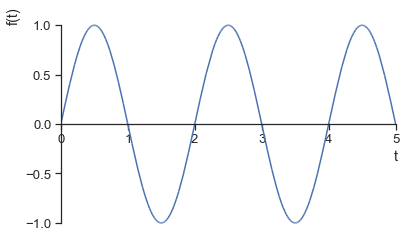

In [3]:
Vin = A * sin(ω*t)
syplot(Vin.subs([(A,1),(ω,pi)]),(t,0,5))

The rectifier has the effect of rectifying Vin, so we take the absolute value. Assuming ideal diodes, there is no loss of voltage as the current passes through the diodes.

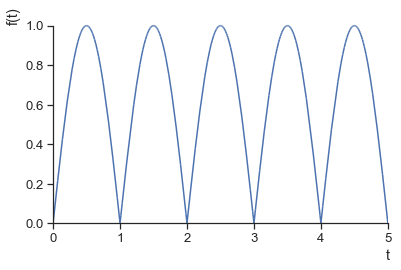

In [4]:
Vrect = Abs(Vin)
syplot(Vrect.subs([(A,1),(ω,pi)]),(t,0,5));

In [62]:
def make_system(params,t_0,t_end, supply_func):
    """Make a system object for the RLEV model.
    
    params(R, L, C): Circuit component values
    
    t_0: Beginning time in seconds
    t_end: Ending time in seconds
    
    returns: System object
    """
    # Start with a number of active, uninfected cells and virons, but no infected cells of any kind
    init = State(Vout=0,dVoutdt=0)
    
    #Get our input waveform function
    Vin = supply_func
    
    #Get our parameters
    R,L,C = params    

    return System(R=R, L=L, C=C, Vin = Vin,
                  t_0=t_0, t_end=t_end, init=init)

In [75]:
def v_source_func(omega = 1, A = 1, phi = 0):
    """
    Defines the source voltage function as a sinusoidal wave changing with respect to time
    Parameters:
        t: Single value representing time, or array of time steps
        A: Amplitude of the sine wave, assumed equal to 1
        phi: Phase shift of the wave, assumed equal to 0
    Returns:
        The function of a standard sine wave A*sin(w*t+phi) with the given parameters
    """
    def v_source(t, omega = omega, A = A, phi = phi):
        return A * np.sin(omega * 6.28 * t + phi)
    
    return v_source

In [76]:
def slope_func(state, t, system):
    """Update the model.
    
    state: State (Vout, dVoutdt)
    t: time
    system: System object
    
    returns: State (dVoutdt, d2Voutdt2)
    """
    Vout, dVoutdt = state
    unpack(system)
    
    d2Voutdt2 = 1/(L*C) * (abs(Vin(t)) - (L/R)*dVoutdt - Vout)
    dVoutdt = (R/L) * (abs(Vin(t)) - (L*C)*d2Voutdt2 - Vout)
    
    return dVoutdt, d2Voutdt2

In [107]:
params = Params(R = 1e3,
               C = 30e-3,
               L = 2.2e-3)

,values
R,1000.0000
C,0.0300
L,0.0022


In [108]:
# Make a system to run for 120 days
system = make_system(params,0,30,v_source_func(60,170,0))
%time results, details = run_ode_solver(system,slope_func,max_step=1e-2);

Wall time: 32.6 s


In [109]:
details

,values
sol,None
t_events,[]
nfev,146588
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


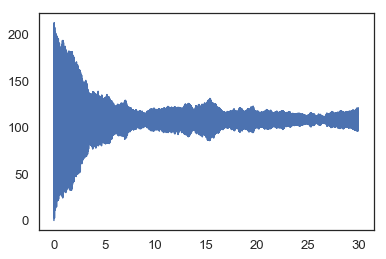

In [110]:
results.Vout.plot()